# Midterm Report

## Import chatGPT detector model

In [3]:
import torch
import io 
import jsonlines
import pandas as pd

In [4]:
model = torch.load('../detector-base.pt') 

## Import dataset HC3

In [1]:
import requests

API_URL = "https://datasets-server.huggingface.co/parquet?dataset=Hello-SimpleAI/HC3"
def query():
    response = requests.request("GET", API_URL)
    return response.json()
data = query()
print(data['parquet_files'][0])

{'dataset': 'Hello-SimpleAI/HC3', 'config': 'all', 'split': 'train', 'url': 'https://huggingface.co/datasets/Hello-SimpleAI/HC3/resolve/refs%2Fconvert%2Fparquet/all/hc3-train.parquet', 'filename': 'hc3-train.parquet', 'size': 39283466}


In [5]:
df = pd.read_parquet(data['parquet_files'][0]['url'])
df.index = df['id']
df.drop(['id'], axis=1, inplace=True)
df.head()

,question,human_answers,chatgpt_answers,source
id,,,,
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,reddit_eli5


In [6]:
df_2 = df

# Establish detector pipeline 

In [98]:
import numpy as np 
max_len=0
min_len = np.inf

counter = 0

for item in df['chatgpt_answers']:
    for second_item in item:
        if len(second_item) > max_len:
            max_len = len(second_item)
        if 16 < len(second_item) < min_len:
            min_len = len(second_item)
        if len(second_item) == 16:
            print(second_item)
        counter = counter + 1
            
#print(min_len)
#print(max_len)
print(counter)

!\nnetwork error
!\nnetwork error
!\nnetwork error
!\nnetwork error
!\nnetwork error
26903


In [7]:
test_case = df['human_answers'][0][0]
test_case

'Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence , # 1 best seller .'

In [8]:
import numpy as nn
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
if device.type == "cpu":
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector"
    )
else:
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector", device_map="auto"
    )

input_text = test_case

input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    logits = model(input_ids).logits

predicted_class_id = logits.argmax().item()
predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
print(
    model.config.id2label[predicted_class_id],
    predicted_probs[nn.argmax(predicted_probs)],
)

/Users/sarah/.local/share/virtualenvs/259-nlp-dE3sWhq_/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Real 0.9998311996459961


# Extract misclassified data

In [ ]:
def get_prediction(df):
    questions = []
    responses = []
    actual_labels = []
    class_labels = []
    class_probs = []
    
    oversized_inputs = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
    if device.type == "cpu":
        model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base-openai-detector"
        )
    else:
        model = AutoModelForSequenceClassification.from_pretrained(
            "roberta-base-openai-detector", device_map="auto"
        )

    counter = 0 
    for id_, row in df.iterrows():
        if counter%50 == 0:
            print(f'Predicting question {counter} out of {len(df)} ({round(counter*100/len(df), 2)}% complete)')
        counter += 1
        
        for real_response in row['human_answers']:
            input_text = real_response
            input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

            if input_ids.shape[1] > 512: # Error handling for max input size 
                input_ids.resize_(input_ids.shape[0], 512)
                oversized_inputs.append(real_response)

            with torch.no_grad():
                logits = model(input_ids).logits

            predicted_class_id = logits.argmax().item()
            predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
            
            questions.append(row['question'])
            responses.append(real_response)
            actual_labels.append('Real')
            class_labels.append(model.config.id2label[predicted_class_id])
            class_probs.append(predicted_probs[nn.argmax(predicted_probs)])
            
            
        for gpt_response in row['chatgpt_answers']:
            input_text = gpt_response
            input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
            
            if input_ids.shape[1] > 512: # Error handling for max input size 
                input_ids.resize_(input_ids.shape[0], 512)
                oversized_inputs.append(gpt_response)

            with torch.no_grad():
                logits = model(input_ids).logits

            predicted_class_id = logits.argmax().item()
            predicted_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
            
            questions.append(row['question'])
            responses.append(real_response)
            actual_labels.append('Fake')
            class_labels.append(model.config.id2label[predicted_class_id])
            class_probs.append(predicted_probs[nn.argmax(predicted_probs)])
            
    output = pd.DataFrame({'question':questions, 'responses':responses, 'actual_label':actual_labels, 'pred_label':class_labels, 'pred_probability':class_probs})

    return output

outputs = get_prediction(df) #get_prediction(df.iloc[0:1000,:])
outputs.head()

Using device: cpu


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicting question 0 out of 24322 (0.0% complete)


Token indices sequence length is longer than the specified maximum sequence length for this model (2028 > 512). Running this sequence through the model will result in indexing errors


Predicting question 50 out of 24322 (0.21% complete)
Predicting question 100 out of 24322 (0.41% complete)
Predicting question 150 out of 24322 (0.62% complete)
Predicting question 200 out of 24322 (0.82% complete)
Predicting question 250 out of 24322 (1.03% complete)
Predicting question 300 out of 24322 (1.23% complete)
Predicting question 350 out of 24322 (1.44% complete)
Predicting question 400 out of 24322 (1.64% complete)
Predicting question 450 out of 24322 (1.85% complete)
Predicting question 500 out of 24322 (2.06% complete)
Predicting question 550 out of 24322 (2.26% complete)
Predicting question 600 out of 24322 (2.47% complete)
Predicting question 650 out of 24322 (2.67% complete)
Predicting question 700 out of 24322 (2.88% complete)
Predicting question 750 out of 24322 (3.08% complete)
Predicting question 800 out of 24322 (3.29% complete)
Predicting question 850 out of 24322 (3.49% complete)
Predicting question 900 out of 24322 (3.7% complete)
Predicting question 950 out of

In [174]:
misclassified_texts = outputs[outputs['actual_label'] != outputs['pred_label']]
misclassified_texts = misclassified_texts.sort_values(by='pred_probability', ascending=True)
misclassified_texts.head(15)

,question,responses,actual_label,pred_label,pred_probability
2530,Would my dead body decompose if sent into space ? I 'm watching Star Troopers and a deceased body has been sent into space . If this happened to me would my body decompose ? Please explain like I'm five.,"Solar radiation would likely pick you apart slowly , just very very slowly .",Real,Fake,0.502060
3805,why diffrent alcohols effect me . I can drink vodka all night and other clear liquors and get drunk with no issue . Yet if I spend the night drinking bourbon I get a terrible hangover . Why is this ? Please explain like I'm five.,* different * affect * just rewrite that sentence,Real,Fake,0.506464
1990,"What happens to someone in a wheelchair when they go to prison ? I ca n't imagine many prisons are wheelchair accessible , and I 've been wondering for ages what happens . Edit : Apparently prisons * * are * * wheelchair accessible Please explain like I'm five.",How do the other prisoners treat them ?,Real,Fake,0.506785
2125,"Why does store bought orange juice ( e.g. Tropicana or the like ) look and taste so different than freshly squeezed orange juice , even though on the box it says made from freshly squeezed oranges ? Thanks in advance ! Please explain like I'm five.","pasteurization , poor quality fruit , and unmentioned added ingredients",Real,Fake,0.508209
1874,How does my ISP ( Suddenlink ) know when I 've tormented something and why do they care ? They 'll disconnect my internet and when I call them tell me its because of something I 've torrented several weeks ago . Please explain like I'm five.,They recieved a letter from the studio that claimed infringement on their copyright . I had Suddenlink ( Abilene ) about 2 years ago before I moved . They will shut off your Internet after 3 letters . The last letter comes by registered mail and if you refuse delivery it will buy you 3 months or so .,Real,Fake,0.509648
...,...,...,...,...,...
3954,How does abortion work ? How does it work ? How is it performed ? What happens to the fetus afterwards ? Are there different kinds of procedures ? Please explain like I'm five.,Once there was a fertilized egg ... now there is n't ( written for actual 5 year olds :-P ),Real,Fake,0.517720
1779,Do animals have phobias ? Are there wild animals out there with the same irrational fears as people ? Please explain like I'm five.,Some large dogs shit themselves and run away in absolute terror at the sight of an big exercise ball .,Fake,Real,0.517879
2232,"Why is it so easy to save a word file as PDF but the opposite way is apparently complex ? If it wasn'nt for free online converters , I would have to PAY for it for Adobe Reader . Please explain like I'm five.",Having word create a PDF is like baking a cake and then taking a picture of it . Creating a word file out of a PDF is like handing someone a photograph of a cake and then telling them to bake it .,Real,Fake,0.522520
1106,"Why do people rub their faces when they are tired ? It feels good , but why ? Please explain like I'm five.",Now I 'm just sitting here rubbing my face like an asshole,Real,Fake,0.525272


# Explore misclassified

In [157]:
confusion_matrix = pd.crosstab(outputs['actual_label'], outputs['pred_label'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  Fake  Real
Actual               
Fake        971    29
Real        124  2876


In [146]:
print(len(outputs))
print(len(misclassified_texts))

from sklearn.metrics import accuracy_score
accuracy_score(outputs['actual_label'], outputs['pred_label'])

4000
153


0.96175

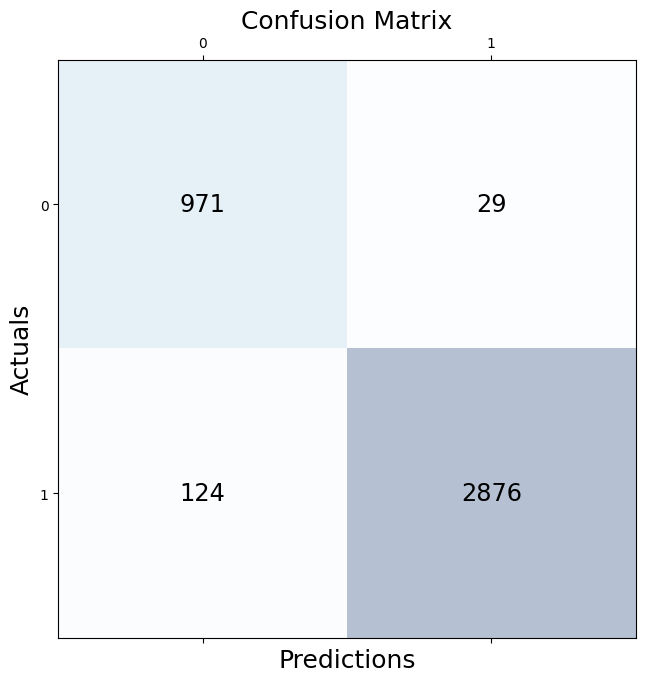

In [143]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(outputs['actual_label'], outputs['pred_label'])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

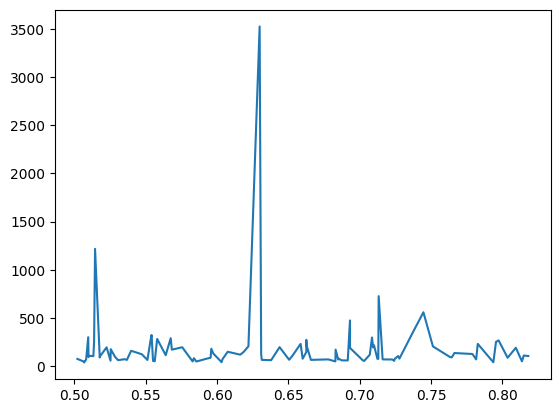

In [178]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

misclassified_texts['char_length'] = [len(i) for i in misclassified_texts['responses']]
misclassified_texts['cum_char_length'] = misclassified_texts['char_length'].cumsum()

#misclassified_texts = misclassified_texts.sort_values(by='pred_probability')

plt.plot(misclassified_texts['pred_probability'][0:100], misclassified_texts['char_length'][0:100])
plt.show()

In [183]:
np.corrcoef(misclassified_texts['char_length'], misclassified_texts['pred_probability'])
from scipy.stats import pearsonr

pearsonr(misclassified_texts['char_length'], misclassified_texts['pred_probability'])

PearsonRResult(statistic=0.07143339516844117, pvalue=0.3802380166296405)

In [176]:
#misclassified_texts.to_csv('misclassified_sample.csv')

# Wordclouding

In [190]:
fake_misclassified_texts = misclassified_texts[misclassified_texts['actual_label']=='Fake']
real_misclassified_texts = misclassified_texts[misclassified_texts['actual_label']=='Real']

FAKE:


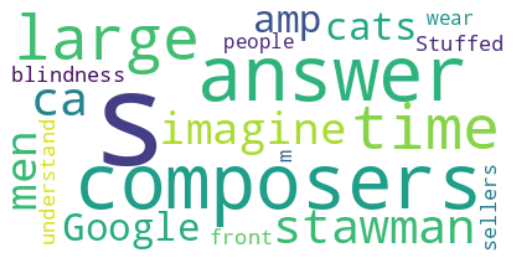

REAL:


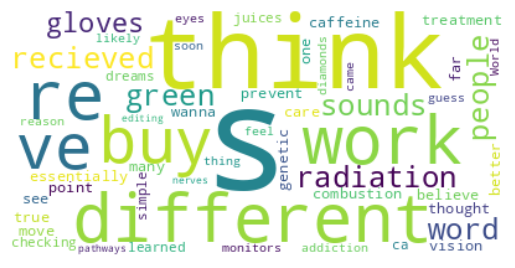

In [193]:
from wordcloud import WordCloud

print('FAKE:')
text = " ".join(cat.split()[1] for cat in fake_misclassified_texts['responses'])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
fake_counts = WordCloud().process_text(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print('REAL:')
text = " ".join(cat.split()[1] for cat in real_misclassified_texts['responses'])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
real_counts = WordCloud().process_text(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [195]:
real_counts

{'radiation': 1,
 'different': 2,
 'recieved': 1,
 'sounds': 1,
 'people': 1,
 'word': 1,
 'green': 1,
 'gloves': 1,
 'essentially': 1,
 's': 5,
 'think': 4,
 'better': 1,
 'believe': 1,
 'far': 1,
 'true': 1,
 'combustion': 1,
 'one': 1,
 'thought': 1,
 'see': 1,
 'wanna': 1,
 'work': 2,
 're': 2,
 'point': 1,
 'treatment': 1,
 'caffeine': 1,
 'prevent': 1,
 'move': 1,
 'vision': 1,
 'care': 1,
 'many': 1,
 'genetic': 1,
 'checking': 1,
 'simple': 1,
 'buy': 2,
 've': 2,
 'learned': 1,
 'juices': 1,
 'dreams': 1,
 'ca': 1,
 'addiction': 1,
 'monitors': 1,
 'guess': 1,
 'eyes': 1,
 'feel': 1,
 'came': 1,
 'World': 1,
 'likely': 1,
 'reason': 1,
 'thing': 1,
 'soon': 1,
 'diamonds': 1,
 'pathways': 1,
 'nerves': 1,
 'editing': 1}

# LEGACY

In [ ]:
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification as AMFSC, AutoTokenizer as AT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = AT.from_pretrained("roberta-base-openai-detector")
if device.type == "cpu":
    model = AMFSC.from_pretrained(
        "roberta-base-openai-detector"
    )
else:
    model = AMFSC.from_pretrained(
        "roberta-base-openai-detector", device_map="auto"
    )

text = new_observation
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    logits = model(input_ids).logits

pred_class_idx = logits.argmax().item()
pred_probs = torch.nn.functional.softmax(logits, dim=1).data.tolist()[0]
print(
    model.config.id2label[pred_class_idx],
    pred_probs[np.argmax(pred_probs)],
)

In [72]:
import torch
from transformers import GPT2Tokenizer

# Load the pre-trained detector model
model_url = "https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt"
model = torch.hub.load_state_dict_from_url(model_url)

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Encode a sample sentence
sentence = "This is a sample sentence."
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=False)

# Pass the encoded input through the detector model
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted label and score
logits = outputs[0]
predicted_label = torch.argmax(logits, dim=1).item()
score = torch.softmax(logits, dim=1)[0][predicted_label].item()

# Print the results
labels = ['human', 'model']
print(f"Sentence: {sentence}")
print(f"Predicted label: {labels[predicted_label]}")
print(f"Score: {score:.2f}")

TypeError: 'dict' object is not callable

In [54]:
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)})

In [60]:
import torch
from transformers import RobertaTokenizer

# Load the pre-trained model
model_path = "https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt"
model = torch.hub.load_state_dict_from_url(model_path)

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input sentence
input_text = "This is a test sentence."
input_ids = tokenizer.encode(input_text, add_special_tokens=True)

# Convert the input to a PyTorch tensor
input_tensor = torch.tensor([input_ids])

# Evaluate the model on the input
with torch.no_grad():
    outputs = model(input_tensor)

# Get the predicted label and score
predicted_label = torch.argmax(outputs[0])
score = torch.softmax(outputs[0], dim=1)[0][predicted_label].item()

# Print the results
labels = ['human', 'model']
print(f"Sentence: {input_text}")
print(f"Predicted label: {labels[predicted_label]}")
print(f"Score: {score:.2f}")


TypeError: 'dict' object is not callable

In [68]:
len(model['model_state_dict'])

203

In [70]:
torch.load('../detector-base.pt', map_location=torch.device('cpu'))

{'model_state_dict': OrderedDict([('roberta.embeddings.word_embeddings.weight',
               tensor([[ 0.1515, -0.0328,  0.0824,  ..., -0.0089,  0.0225, -0.0009],
                       [ 0.0156,  0.0076, -0.0118,  ..., -0.0022,  0.0081, -0.0156],
                       [-0.0346, -0.0804, -0.0232,  ...,  0.1155, -0.0067, -0.0290],
                       ...,
                       [ 0.0304,  0.0504, -0.0307,  ...,  0.0377,  0.0096,  0.0084],
                       [ 0.0623, -0.0596,  0.0307,  ..., -0.0920,  0.1080, -0.0183],
                       [ 0.1259, -0.0145,  0.0332,  ...,  0.0121,  0.0342,  0.0168]])),
              ('roberta.embeddings.position_embeddings.weight',
               tensor([[-0.0115,  0.0204,  0.0197,  ...,  0.0050, -0.0274, -0.0439],
                       [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                       [ 0.0385, -0.0132, -0.0825,  ..., -0.0608,  0.0344,  0.0180],
                       ...,
                       [ 0.1191,